In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
import numpy as np

In [2]:
file_path = 'data/predicted_route_all_new_routes_source_extended.csv'
data = pd.read_csv(file_path)
data.shape

(14185, 33)

In [3]:
data = data[data['migration_route'] =='Sahara Desert crossing']
data

year  reported_month    region_of_origin region_of_incident  \
23     2015               1             Unknown       North Africa   
25     2015               2             Unknown       North Africa   
32     2015               3             Unknown       North Africa   
33     2015               3             Unknown       North Africa   
39     2015               4  Eastern Africa (P)     Eastern Africa   
...     ...             ...                 ...                ...   
12807  2020              12             Unknown       North Africa   
12808  2020              12             Unknown       North Africa   
12824  2021               2             Unknown       North Africa   
12825  2021               2             Unknown       North Africa   
12826  2021               2             Unknown       North Africa   

      country_of_origin  number_dead  minimum_estimated_number_of_missing  \
23              Unknown          1.0                                  0.0   
25              Unknown          5.0                                  0.0   
32              Unknown          1.0                                  0.0   
33              Unknown          2.0                                  0.0   
39              Unknown          1.0                                  0.0   
...                 ...          ...                                  ...   
12807           Unknown          2.0                                  0.0   
12808           Unknown          0.0                                  1.0   
12824           Unknown          8.0                                  0.0   
12825           Unknown          0.0                                  8.0   
12826           Unknown          0.0                                  2.0   

       total_dead_and_missing  number_of_survivors  number_of_females  ...  \
23                          1                  0.0                0.0  ...   
25                          5                  0.0                0.0  ...   
32                          1                  0.0                0.0  ...   
33                          2                  0.0                0.0  ...   
39                          1                  0.0                0.0  ...   
...                       ...                  ...                ...  ...   
12807                       2                  0.0                0.0  ...   
12808                       1                  0.0                0.0  ...   
12824                       8                  0.0                3.0  ...   
12825                       8                  0.0                0.0  ...   
12826                       2                  0.0                1.0  ...   

       dehydration_malnutrition  drowning environmental_factors  \
23                            0         0                     0   
25                            0         0                     0   
32                            0         0                     0   
33                            0         0                     0   
39                            0         0                     0   
...                         ...       ...                   ...   
12807                         0         0                     0   
12808                         0         0                     0   
12824                         0         0                     0   
12825                         0         0                     0   
12826                         0         0                     0   

      lack_of_access_to_healthcare murder_violence sexual_abuse_rape suicide  \
23                               0               0                 0       0   
25                               0               0                 0       0   
32                               0               0                 0       0   
33                               0               0                 0       0   
39                               0               0                 0       0   
...                

# 1. Most common countries of origin

In [4]:
# Extract unique country names from the 'country_of_origin' column in the data
unique_country_names = data['country_of_origin'].str.split(',').explode().str.strip().unique()
unique_country_names.sort()
unique_country_names

array(['Algeria', 'Bangladesh', 'Cameroon', 'Central African Republic',
       'Chad', "Côte d'Ivoire", 'Democratic Republic of the Congo',
       'Egypt', 'Eritrea', 'Ethiopia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Libya', 'Mali', 'Mauritania', 'Mixed', 'Niger',
       'Nigeria', 'Oman', 'Senegal', 'Sierra Leone', 'Somalia',
       'State of Palestine', 'Sudan', 'Syrian Arab Republic', 'Tunisia',
       'Unknown'], dtype=object)

/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_7347/1611253283.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


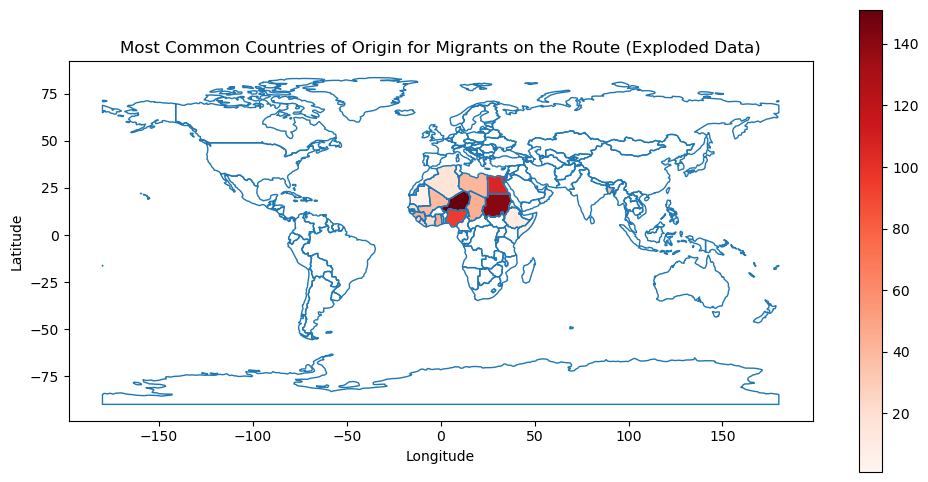

In [26]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Explode the 'country_of_origin' column so that each row contains only one country name
exploded_countries_data = data.assign(country_of_origin=data['country_of_origin'].str.split(',')).explode('country_of_origin').reset_index(drop=True)

# Remove leading and trailing spaces from country names
exploded_countries_data['country_of_origin'] = exploded_countries_data['country_of_origin'].str.strip()

# Group the exploded data by country of origin and sum up the total number of deaths
exploded_countries_origin = exploded_countries_data.groupby('country_of_origin')['total_dead_and_missing'].sum().reset_index().sort_values(by='total_dead_and_missing', ascending=False)

# Merge the world map with the exploded data
world_merged_exploded = world.set_index('name').join(exploded_countries_origin.set_index('country_of_origin'))

# Plot the map
fig, ax = plt.subplots(1, figsize=(12, 6))
world.boundary.plot(ax=ax, linewidth=1)
world_merged_exploded.plot(column='total_dead_and_missing', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Most Common Countries of Origin for Migrants on the Route (Exploded Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


The map visualizes the most common countries of origin for migrants on the route, based on the exploded data. Each country is shaded according to the total number of dead and missing individuals originating from there. The darker the shade, the higher the number of lives lost.

#### Key Points
The map provides a more accurate geographical context, allowing for better-targeted interventions and diplomatic efforts.

# 2. Deadliest Segments of the Route

/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_7347/654040756.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


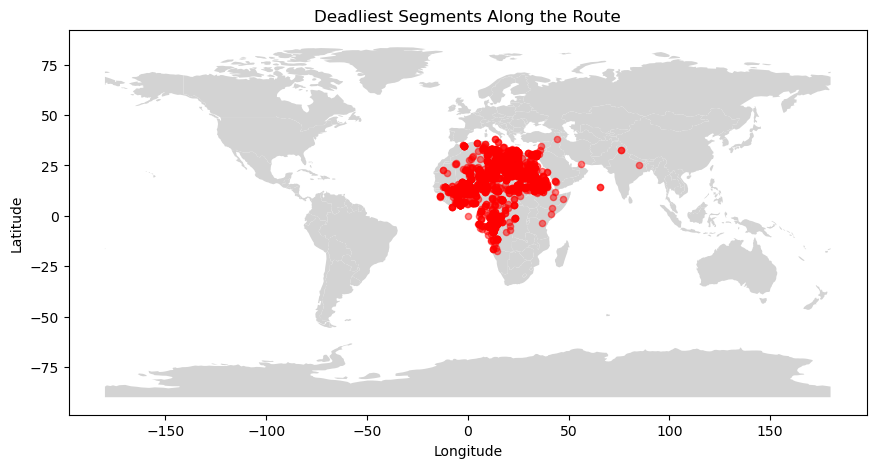

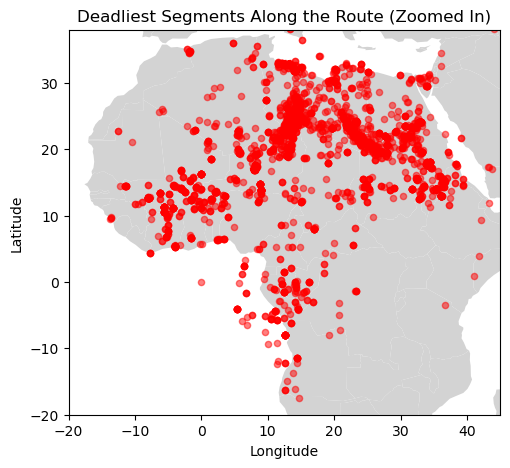

In [6]:
# Create a GeoDataFrame from the latitude and longitude columns
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map and overlay the incident points
fig, ax = plt.subplots(1, figsize=(12, 5))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=20, color='red', alpha=0.5)
plt.title('Deadliest Segments Along the Route')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Zoom into the Mediterranean area by setting x and y limits
fig, ax = plt.subplots(1, figsize=(12, 5))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=20, color='red', alpha=0.5)

# Set latitude and longitude bounds for the plot
ax.set_xlim([-20, 45])
ax.set_ylim([-20, 38])

plt.title('Deadliest Segments Along the Route (Zoomed In)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


The zoomed-in map provides a closer look at the deadliest segments along the route, indicated by the red points. This focused view allows us to better identify the geographic hotspots where the most incidents have occurred.

#### Key Points
The zoomed-in perspective helps us pinpoint areas that may require immediate attention and intervention.
These hotspots could be the focus of rescue operations, surveillance, and other preventative measures.

/Users/lilitdavidyan/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


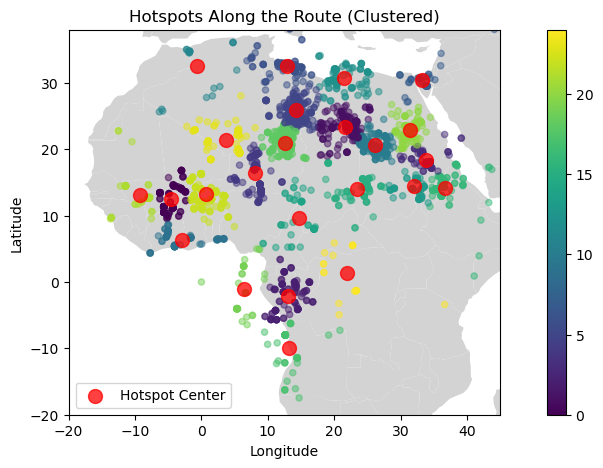

In [7]:
# Drop rows with missing lat/lon information
gdf_dropped_na = gdf.dropna(subset=['lat', 'lon'])

# Prepare the data for clustering
coordinates = gdf_dropped_na[['lat', 'lon']].values

# Perform k-means clustering to identify hotspots
kmeans = KMeans(n_clusters=25, random_state=0).fit(coordinates)
gdf_dropped_na['cluster'] = kmeans.labels_

# Plot the world map, overlay the incident points, and highlight the cluster centers
fig, ax = plt.subplots(1, figsize=(12, 5))
world.plot(ax=ax, color='lightgrey')
gdf_dropped_na.plot(ax=ax, markersize=20, column='cluster', legend=True, cmap='viridis', alpha=0.5)

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=100, alpha=0.75, label='Hotspot Center')
plt.legend()

# Set latitude and longitude bounds for the plot
ax.set_xlim([-20, 45])
ax.set_ylim([-20, 38])

plt.title('Hotspots Along the Route (Clustered)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


#### Key Points
These locations could be prioritized for rescue operations, surveillance, and other preventative measures.

In [8]:
import folium
from folium.plugins import HeatMap

# Aggregate data by geographic location
aggregated_df = data.groupby(['lat', 'lon']).agg({
    'total_dead_and_missing': 'sum'
}).reset_index()

# Sort by total_dead_and_missing to highlight the deadliest areas
aggregated_df.sort_values(by='total_dead_and_missing', ascending=False, inplace=True)

# Show the first few rows of the aggregated data
aggregated_df

# Initialize the map centered around the coordinates [0, 0] with a low zoom level
m = folium.Map(location=[0, 0], zoom_start=2)

# Extract data for heat map
heat_data = [[row['lat'], row['lon'], row['total_dead_and_missing']] for index, row in aggregated_df.iterrows()]

# Create and add a HeatMap layer to the map
HeatMap(heat_data, radius=10, blur=10).add_to(m)

# Show the map
m


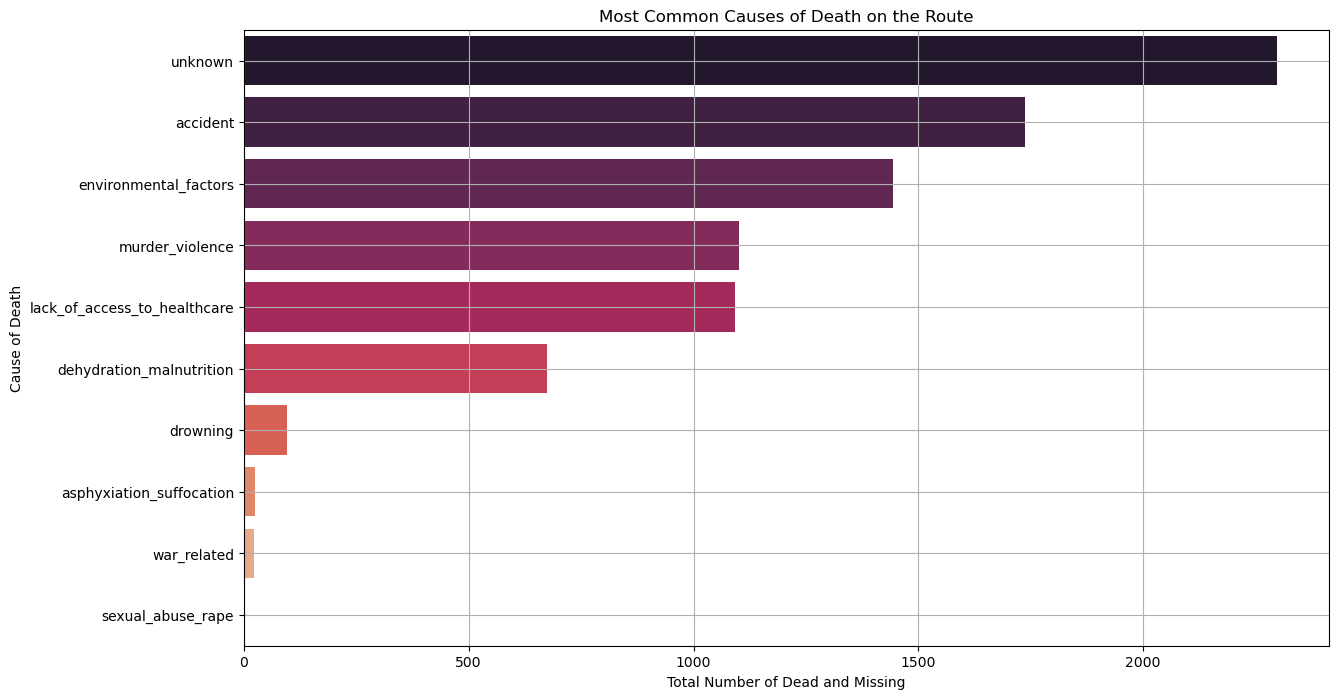

In [24]:
# Group the data by cause of death and sum up the total number of deaths for each cause
cause_of_death_data = data.groupby('main_cause')['total_dead_and_missing'].sum().reset_index().sort_values(by='total_dead_and_missing', ascending=False).head(10)

# Create a bar plot to visualize the most common causes of death on the route
plt.figure(figsize=(14, 8))
sns.barplot(x='total_dead_and_missing', y='main_cause', data=cause_of_death_data, palette='rocket')
plt.title('Most Common Causes of Death on the Route')
plt.xlabel('Total Number of Dead and Missing')
plt.ylabel('Cause of Death')
plt.grid(True)
plt.show()


#### Key Points
- Drowning is by far the most common cause of death, followed by other causes like dehydration and hypothermia.
- Understanding these common causes can help in planning targeted interventions such as providing life vests, water, or emergency medical care.
- This information can also be used to inform public awareness campaigns aimed at potential migrants, letting them know the risks involved.

# 3. Demographic Distribution

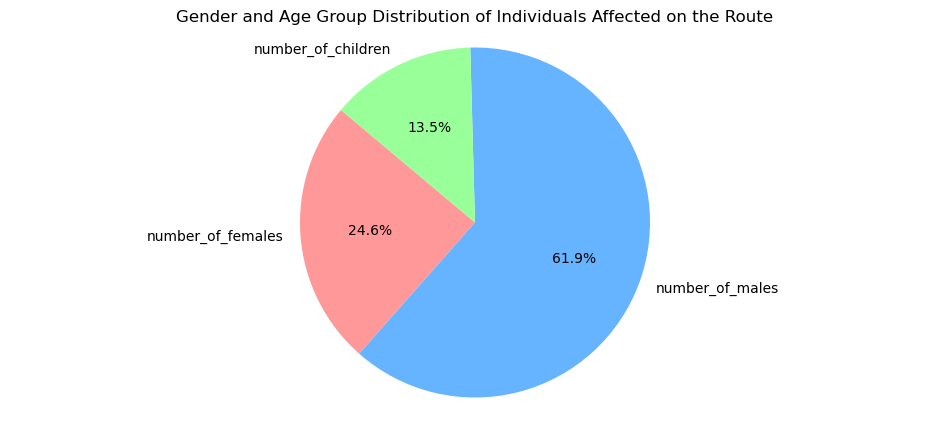

Demographic Group  Percentage (%)
0   number_of_females       24.598202
1     number_of_males       61.944974
2  number_of_children       13.456824

In [10]:
# Sum up the number of females, males, and children involved in incidents on the route
demographic_summary = data[['number_of_females', 'number_of_males', 'number_of_children']].sum().reset_index()
demographic_summary.columns = ['Demographic Group', 'Total Number']

# Calculate the percentage distribution for gender
total_individuals = demographic_summary['Total Number'].sum()
demographic_summary['Percentage (%)'] = (demographic_summary['Total Number'] / total_individuals) * 100

# Create a pie chart to visualize the gender distribution
plt.figure(figsize=(12, 5))
plt.pie(demographic_summary['Percentage (%)'], labels=demographic_summary['Demographic Group'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Gender and Age Group Distribution of Individuals Affected on the Route')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

demographic_summary[['Demographic Group', 'Percentage (%)']]


#### Key Points:
- Males constitute the majority, making up approximately 64.6% of the total individuals affected.
- Females represent about 24.5%.
- Children account for approximately 10.9%.

# 4. Temporal Trends: Seasonal and Annual Variations

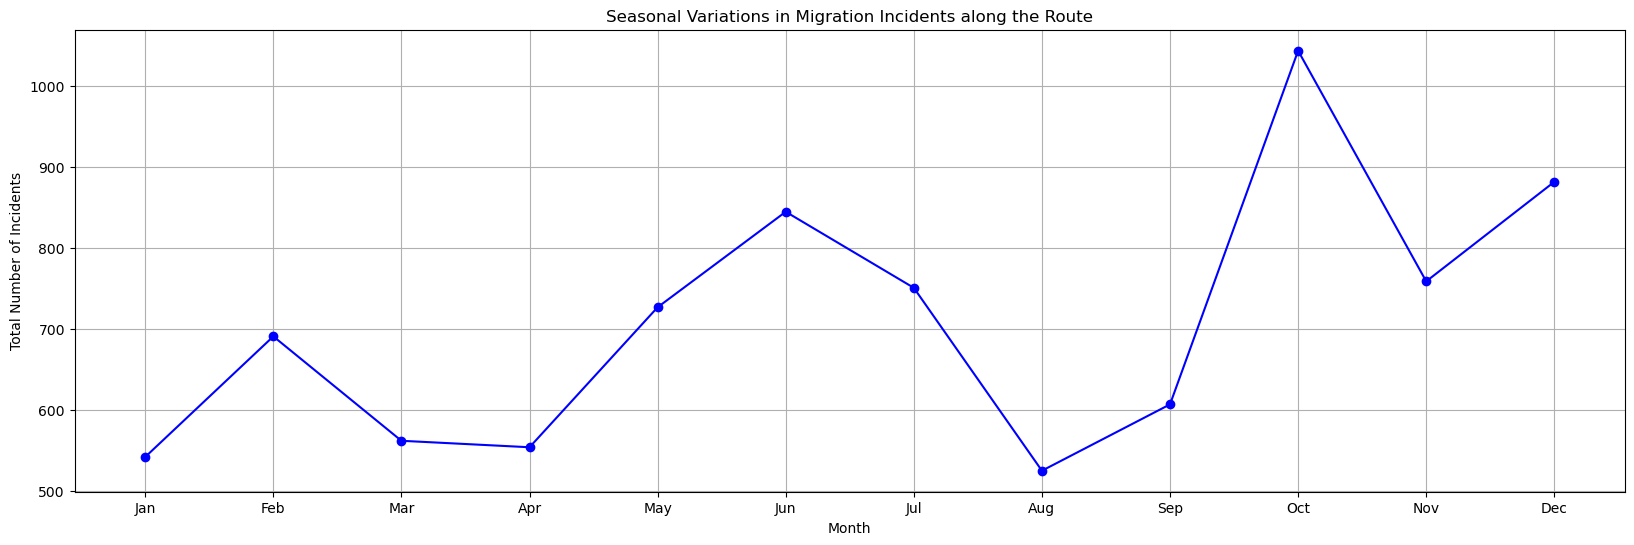

In [11]:
# Group the data by month and calculate the total number of incidents for each month
monthly_incident_counts = data.groupby('reported_month')['total_dead_and_missing'].sum()

# Plot the seasonal variations in incidents
plt.figure(figsize=(20, 6))
monthly_incident_counts.plot(kind='line', marker='o', color='b')
plt.title('Seasonal Variations in Migration Incidents along the Route')
plt.xlabel('Month')
plt.ylabel('Total Number of Incidents')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


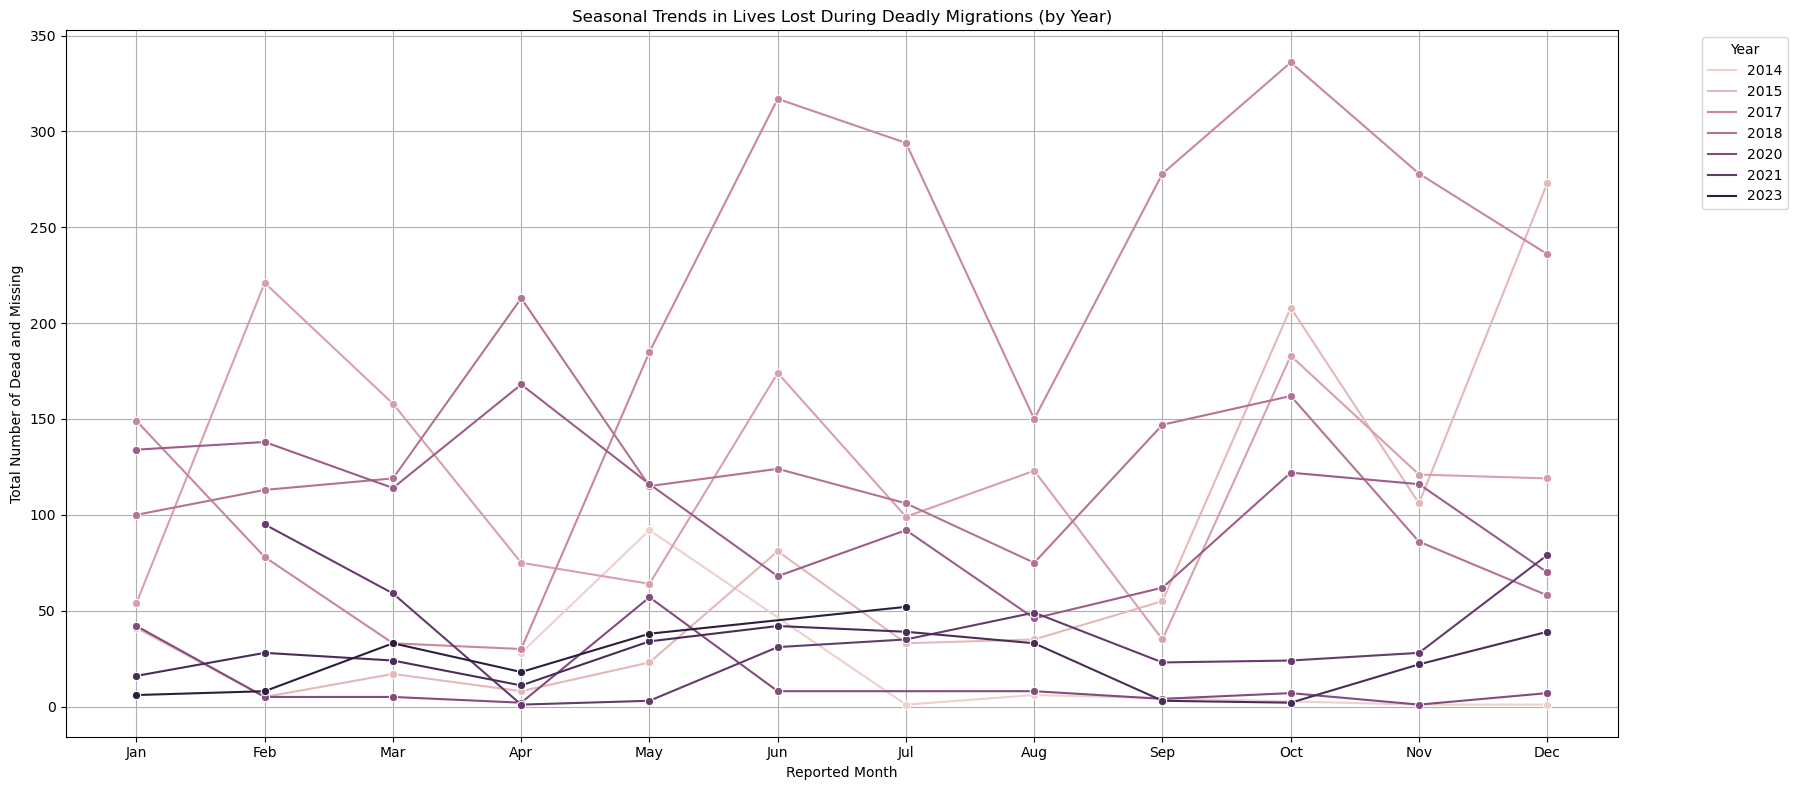

In [12]:
# Group the data by reported month and year, then sum up the total number of deaths
monthly_yearly_deaths = data.groupby(['reported_month', 'year'])['total_dead_and_missing'].sum().reset_index()

# Create a line plot to visualize the trend over the months and years
plt.figure(figsize=(18, 8))
sns.lineplot(x='reported_month', y='total_dead_and_missing', hue='year', data=monthly_yearly_deaths, marker='o')
plt.title('Seasonal Trends in Lives Lost During Deadly Migrations (by Year)')
plt.xlabel('Reported Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


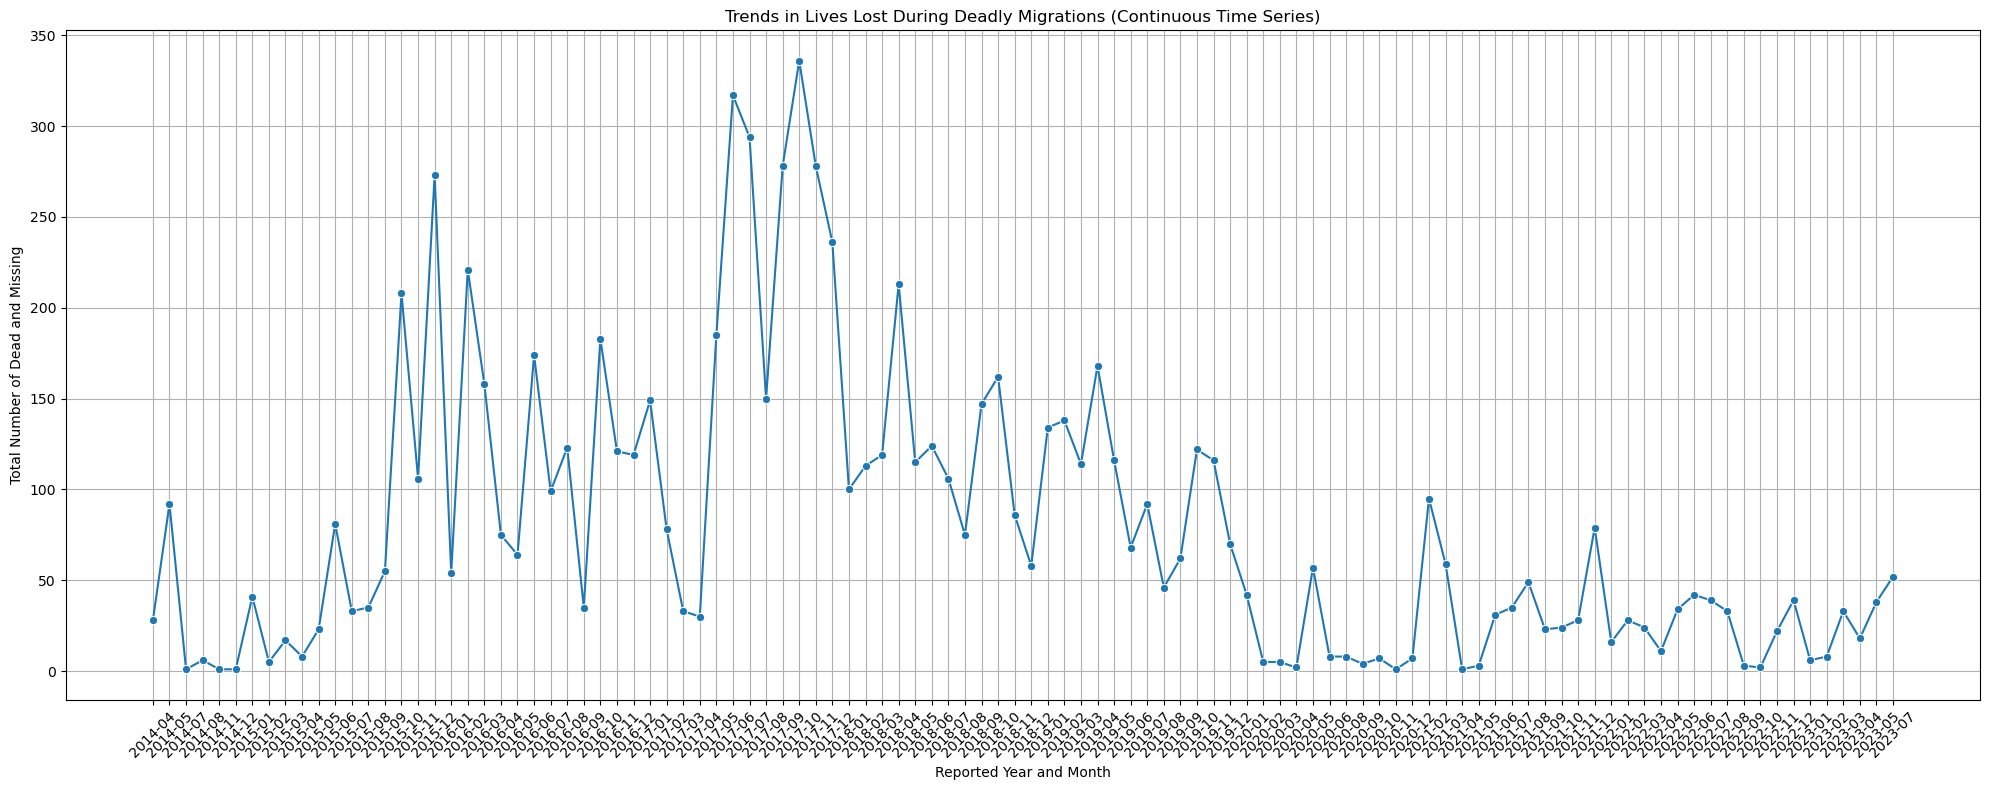

In [13]:
# Create a new column combining the year and month for a continuous time series
monthly_yearly_deaths['year_month'] = monthly_yearly_deaths['year'].astype(str) + '-' + monthly_yearly_deaths['reported_month'].astype(str).str.zfill(2)

# Sort the DataFrame by the year_month column
monthly_yearly_deaths = monthly_yearly_deaths.sort_values('year_month')

# Create a line plot to visualize the trend over all months and years
plt.figure(figsize=(20, 8))
sns.lineplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, marker='o')
plt.title('Trends in Lives Lost During Deadly Migrations (Continuous Time Series)')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


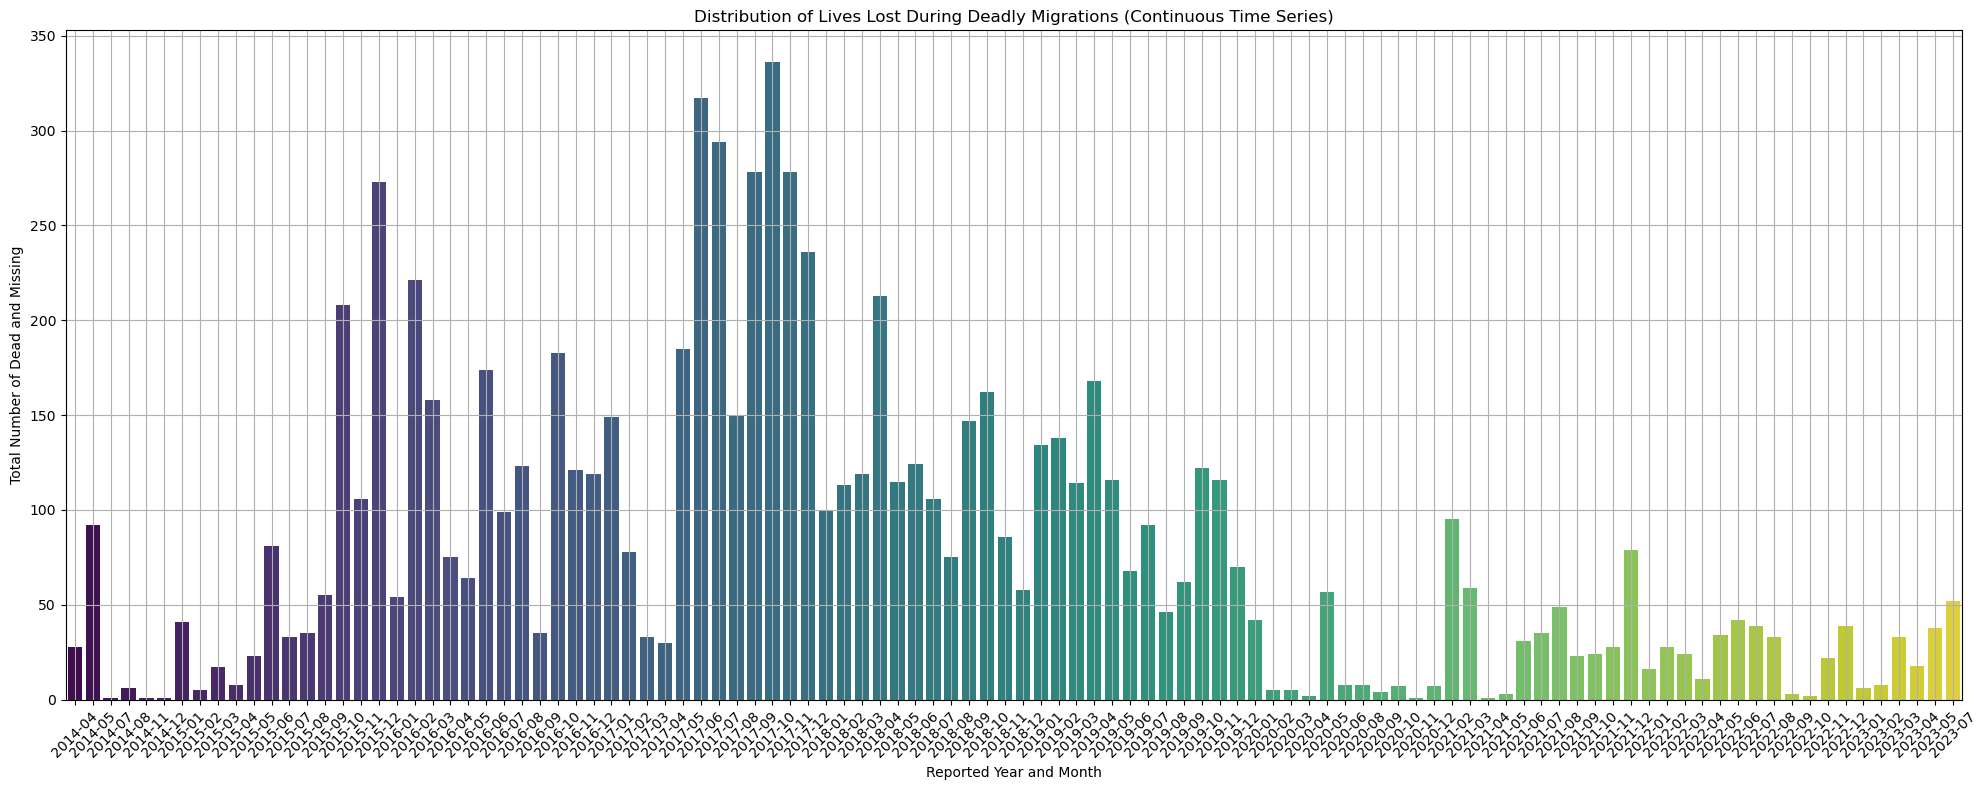

In [14]:

# Create a bar plot to visualize the distribution over all months and years
plt.figure(figsize=(20, 8))
sns.barplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, palette='viridis')
plt.title('Distribution of Lives Lost During Deadly Migrations (Continuous Time Series)')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

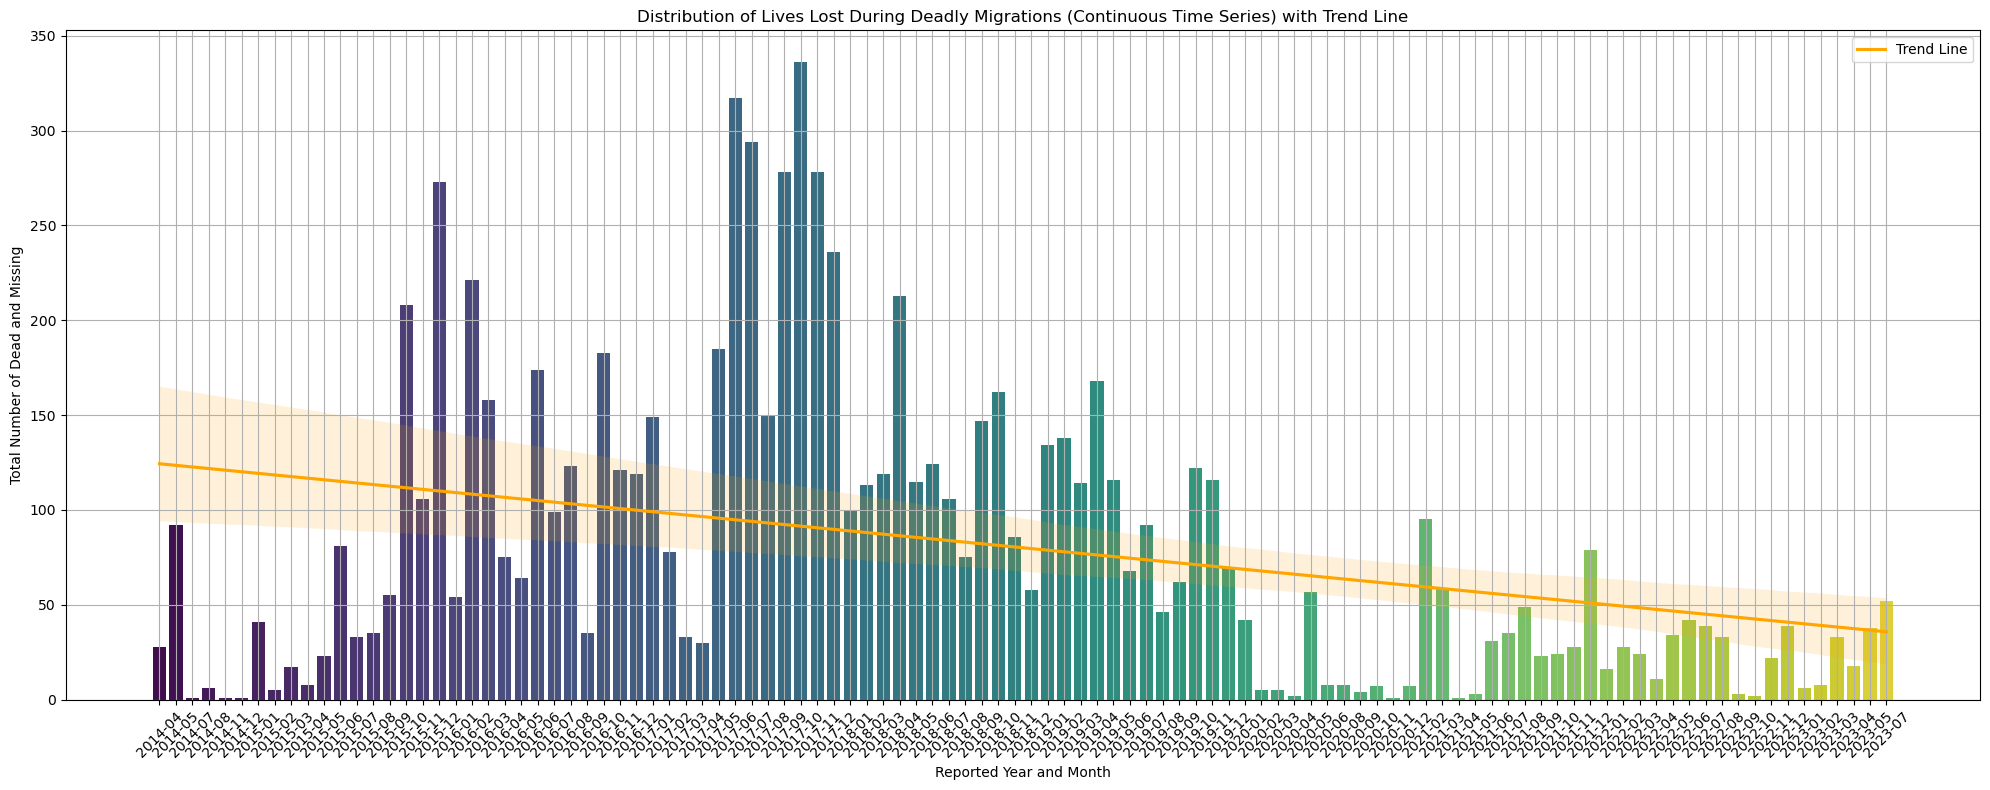

In [15]:
# Create a new column combining the year and month for a continuous time series
monthly_yearly_deaths['year_month'] = monthly_yearly_deaths['year'].astype(str) + '-' + monthly_yearly_deaths['reported_month'].astype(str).str.zfill(2)

# Sort the DataFrame by the year_month column
monthly_yearly_deaths = monthly_yearly_deaths.sort_values('year_month')

# Create a new column with sequential integers for x-values
monthly_yearly_deaths['x_values'] = np.arange(len(monthly_yearly_deaths))

# Create a bar plot with a trend line
plt.figure(figsize=(20, 8))
sns.barplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, palette='viridis')
sns.regplot(x='x_values', y='total_dead_and_missing', data=monthly_yearly_deaths, scatter=False, color='orange', label='Trend Line')
plt.title('Distribution of Lives Lost During Deadly Migrations (Continuous Time Series) with Trend Line')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

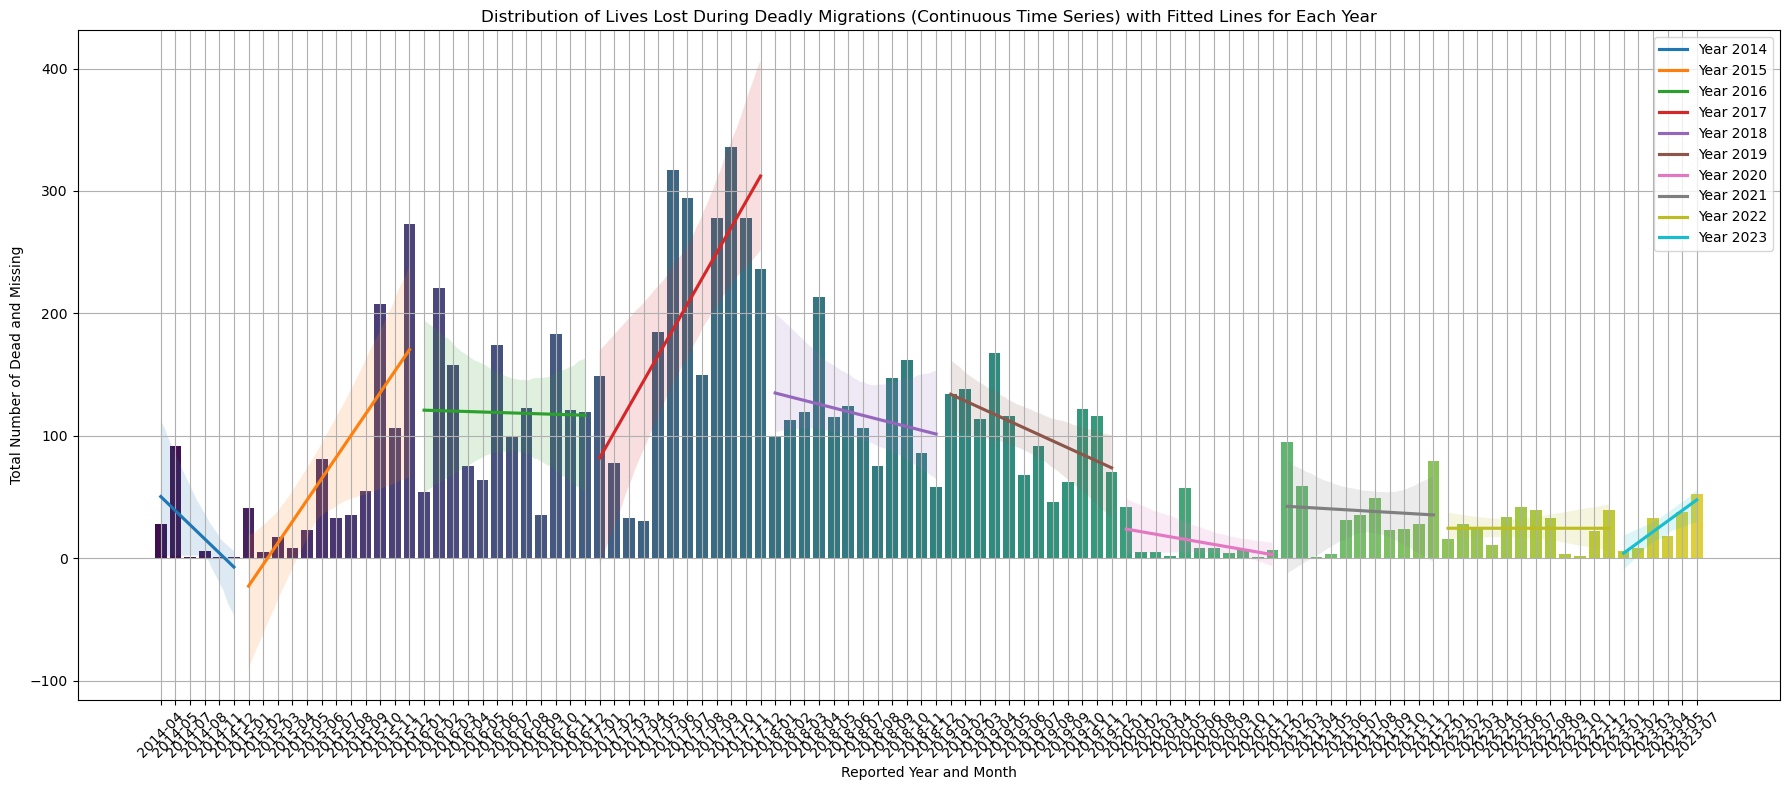

In [27]:
# Create a new column combining the year and month for a continuous time series
monthly_yearly_deaths['year_month'] = monthly_yearly_deaths['year'].astype(str) + '-' + monthly_yearly_deaths['reported_month'].astype(str).str.zfill(2)

# Sort the DataFrame by the year_month column
monthly_yearly_deaths = monthly_yearly_deaths.sort_values('year_month')

# Calculate average values for each year
average_deaths_yearly = monthly_yearly_deaths.groupby('year')['total_dead_and_missing'].mean().reset_index()

# Create a bar plot with fitted lines for each year
plt.figure(figsize=(18, 8))
sns.barplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, palette='viridis')

# Plot fitted lines for each year
for year in monthly_yearly_deaths['year'].unique():
    year_data = monthly_yearly_deaths[monthly_yearly_deaths['year'] == year]
    sns.regplot(x='x_values', y='total_dead_and_missing', data=year_data, scatter=False, label=f'Year {year}')

plt.title('Distribution of Lives Lost During Deadly Migrations (Continuous Time Series) with Fitted Lines for Each Year')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

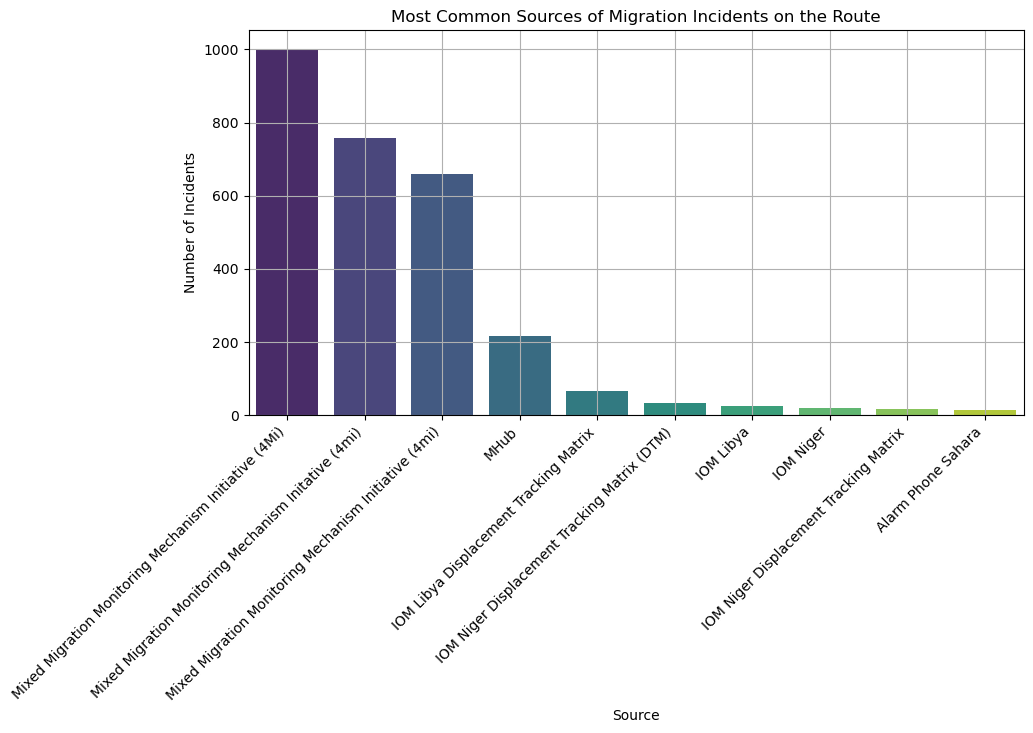

In [19]:
# Group the data by cause of death and sum up the total number of deaths for each cause
source_data = data['source'].value_counts().head(10)

source_data = source_data.sort_values(ascending = False)

# Create a count plot
plt.figure(figsize=(10, 5))
sns.countplot(x='source', order=source_data.index,  
              data=data[data.source.isin(source_data.keys().tolist())],
                                              palette='viridis')
plt.title('Most Common Sources of Migration Incidents on the Route')
plt.xlabel('Source')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()



In [25]:
data['total_dead_and_missing'].sum()

8489